# Test run of import + preprocessing of files

First will attempt with the data from the [ERP CORE](https://erpinfo.org/erp-core) EEG data, formatted in .set/.fdt, before trying with own .bdf files.

In [1]:
%matplotlib qt

In [2]:
import os
import numpy as np
import mne

## Loading data

ERP CORE data have been downloaded into the MNE folder (current testing grounds for this process). We will be using the MMN data generated with the Näätänen et al. paradigm.


In [3]:
# file_path = os.path.join(os.path.expanduser('~/'), 'Documents', 'Courses', 'Developing','EEG lab','MNE')
file_path = os.path.join('G:\\', 'My Drive', 'Spring 2023', 'EEG', 'EEG lab','MNE')
mmn_path = os.path.join(file_path, 'N400_raw')
print(mmn_path) # sanity check #1

G:\My Drive\Spring 2023\EEG\EEG lab\MNE\N400_raw


In [139]:
# first try with one subject
subject = 25
filename = str(subject) + "_N400.set"
mmn_subj_file = os.path.join(mmn_path, str(subject), filename)
raw = mne.io.read_raw_eeglab(mmn_subj_file, preload=True)

Reading G:\My Drive\Spring 2023\EEG\EEG lab\MNE\N400_raw\25\25_N400.fdt
Reading 0 ... 435199  =      0.000 ...   424.999 secs...


In [ ]:
print(raw.info)
print(raw)

In [140]:
# need to rename the 'HEOG_left' 'HEOG_right' and 'VEOG_lower' channels
# also rename 'FP1' and 'FP2' to lowercase?

raw.rename_channels({'FP1': 'Fp1', 'FP2': 'Fp2'})
raw.set_channel_types({'HEOG_left': 'eog', 'HEOG_right': 'eog', 'VEOG_lower': 'eog'})
raw.set_montage('biosemi64')

<RawEEGLAB | 25_N400.fdt, 33 x 435200 (425.0 s), ~109.6 MB, data loaded>

In [ ]:
# try saving interim file:
rawname = str(subject) + '_N400_eeg.fif'
raw.save(rawname)

## Finding events

We need to load in the events for the MMN.

In [141]:
# the event codes are noted in as annotations and not events, so mne.find_events(raw) won't work here
# use mne.events_from_annotations instead

print(raw.annotations)
print(set(raw.annotations.description))

<Annotations | 363 segments: 111 (30), 112 (30), 121 (30), 122 (30), 201 ...>
{'222', '202', '111', '221', '211', '212', '201', '112', '122', '121'}


In [142]:
# from the event code file in the MMN documents:
# 180 is the first 15 standards (we don't include those)
# 70 is deviant, 80 is standard
# we need to name them in events as such

events_from_annot, event_dict = mne.events_from_annotations(raw)
print(events_from_annot[:5])
event_dict = {'prime/related/list1': 1, 'prime/related/list2': 2, 'prime/unrelated/list1': 3, 'prime/unrelated/list2': 4, 
              'target/related/list1': 7, 'target/related/list2': 8,'target/unrelated/list1': 9, 'target/unrelated/list2': 10,
              'correct': 5, 'incorrect': 6}

Used Annotations descriptions: ['111', '112', '121', '122', '201', '202', '211', '212', '221', '222']
[[ 5313     0     6]
 [16290     0     6]
 [20377     0     2]
 [21520     0     8]
 [22147     0     5]]


In [ ]:
# in the N400 dataset, in the original ERP CORE all event codes were shifted 26 ms. Let's try to do that here:
events_rev = []
time_list = [i[0] for i in events_from_annot]
#print(time_list)
for idx, x in enumerate(time_list):
    new_event = [x + 26,events_from_annot[idx][1],events_from_annot[idx][2]]
    events_rev.append(new_event)
print(events_rev[:5])

In [143]:
# plotting events

fig = mne.viz.plot_events(events_from_annot, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_dict)
fig.subplots_adjust(right=0.7)  # make room for legend

In [ ]:
# plot alongside the raw data
# locate the bad channels

raw.plot(events=events_from_annot, duration = 60, n_channels=len(raw.ch_names), color = 'black', scalings = 'auto', highpass = 0.1, lowpass = 40)

# the data are clearly not preprocessed yet lol. filtered to better visualize
# C5, F4, F8 (Oz at the end but it's probably okay)

# we also need to crop the start and end to remove the segments that aren't part of the test

#raw.crop(tmin=14, tmax=600 if raw.times[-1] > 600 else raw.times[-1])

In [ ]:
raw.plot_psd(average=True)
# data are not filtered yet, so there isn't a filter line showing where it would be applied.

In [ ]:
raw.plot_sensors() # no channels have been marked as bad yet.

## Preprocessing

Steps to preprocessing: 

1. Mark bad channels
2. Mark bad segments by visualizing
3. High-pass filter 0.5 Hz
4. Rereferencing data to average
5. ICA to remove artifacts
6. Interpolate channels (possibly move later to after ICA)
7. Epoch data 
8. Exclude epochs based on channel amplitude
9. Low-pass filter 30 Hz

In [127]:
# marking bad channels by appending to raw

raw.info['bads']=[]
raw.info['bads'].extend(['Fp2', 'P8'])
print(raw.info['bads'])

['Fp2', 'P8']


Setting up band-pass filter from 0.1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 40.00 Hz: -6.02, -6.02 dB



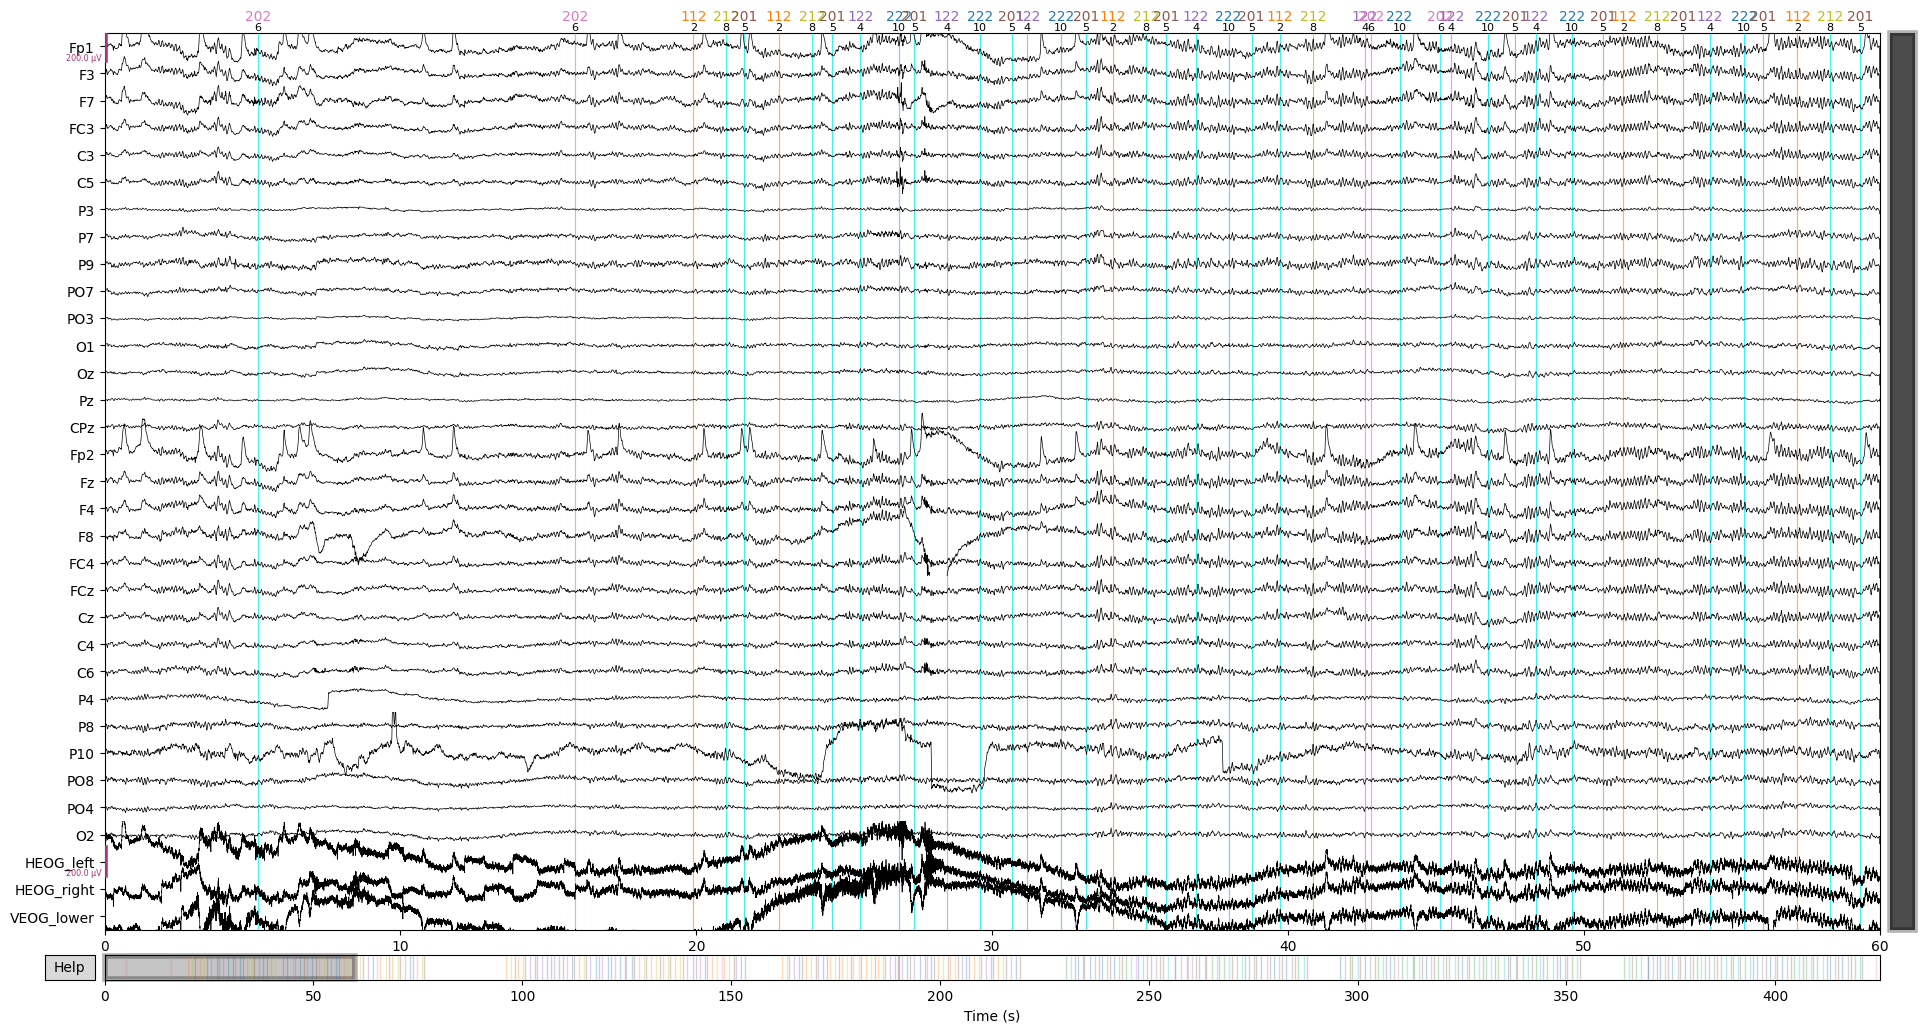

Channels marked as bad:
none


In [144]:
# mark bad segments via raw.plot

raw.plot(events=events_from_annot, duration = 60, n_channels=len(raw.ch_names), color = 'black', scalings = 100e-6, highpass = 0.1, lowpass = 40)

# if segments are rejected here (marked bad), make sure they are excluded when running the ICA.

### Note: ignore the next segment for the ICA bit

In [ ]:
# aside: ocular artifact detection

eog_events = mne.preprocessing.find_eog_events(raw)
onsets = eog_events[:, 0] / raw.info['sfreq'] - 0.25
durations = [0.5] * len(eog_events)
descriptions = ['bad blink'] * len(eog_events)
blink_annot = mne.Annotations(onsets, durations, descriptions,
                              orig_time=raw.info['meas_date'])
raw.set_annotations(blink_annot)

# visualization to see if the annotations are marked
raw.plot(events = eog_events, duration = 60, n_channels=len(raw.ch_names), color = 'black',
        scalings = 'auto', highpass = 0.1, lowpass = 40)

### Resume here

In [145]:
# high-pass filtering raw data

raw_hpass = raw.copy().filter(l_freq = 0.1, h_freq = None)
# fig = raw_hpass.plot(duration=60, proj=False,
#                            n_channels=len(raw_hpass.ch_names), remove_dc=False)
# fig.subplots_adjust(top=0.9)
# fig.suptitle('High-pass filtered at {} Hz'.format(0.1), size='xx-large',
#                 weight='bold')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33793 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.7s finished


In [146]:
# running ICA to remove ocular (and other) artifacts
# filtering at 1 Hz for the ICA before reapplying the ICA to the unfiltered signal

filt_raw = raw.copy()
filt_raw.load_data().filter(l_freq = 1, h_freq = None)

ica = mne.preprocessing.ICA(max_iter = 'auto')
ica.fit(filt_raw, reject_by_annotation = True)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Omitting 64246 of 435200 (14.76%) samples, retaining 370954 (85.24%) samples.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished


Selecting by non-zero PCA components: 30 components
Fitting ICA took 11.5s.


Method,fastica
Fit,35 iterations on raw data (370954 samples)
ICA components,30
Available PCA components,30
Channel types,eeg
ICA components marked for exclusion,—


In [147]:
# with ICA completed, visualize on original raw data:

raw_hpass.load_data()
ica.plot_sources(raw_hpass)
ica.plot_components()

Creating RawArray with float64 data, n_channels=33, n_times=435200
    Range : 0 ... 435199 =      0.000 ...   424.999 secs
Ready.


[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 10 Axes>]

Using EOG channels: HEOG_left, HEOG_right, VEOG_lower
Omitting 41364 of 409600 (10.10%) samples, retaining 368236 (89.90%) samples.
Omitting 41364 of 409600 (10.10%) samples, retaining 368236 (89.90%) samples.
Omitting 41364 of 409600 (10.10%) samples, retaining 368236 (89.90%) samples.
Omitting 41364 of 409600 (10.10%) samples, retaining 368236 (89.90%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Omitting 41364 of 409600 (10.10%) samples, retaining 368236 (89.90%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Omitting 41364 of 409600 (10.10%) samples, retaining 368236 (89.90%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


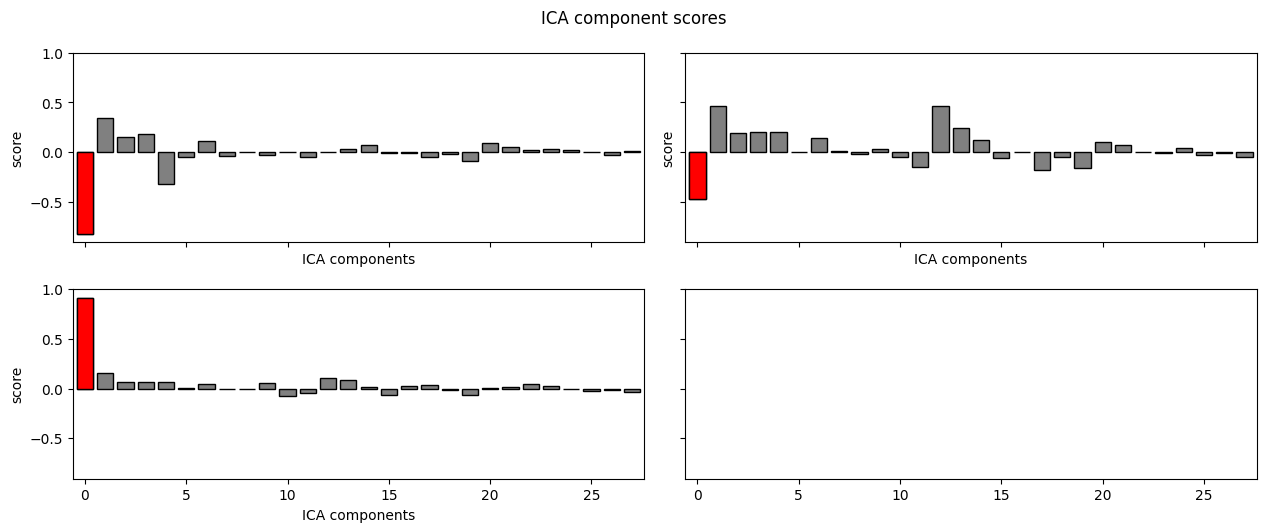

In [132]:
# finding ICA for ocular artifacts

eog_indices, eog_scores = ica.find_bads_eog(raw_hpass)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
#ica.plot_properties(raw_hpass, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
# ica.plot_sources(raw_hpass, show_scrollbars=False)

In [133]:
# ICA000 is rejected as the blink artifact.

# apply the ICA ocular artifact
ica_raw = ica.apply(raw_hpass, exclude = ica.exclude)

Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 1 ICA component
    Projecting back using 28 PCA components


In [ ]:
ica.plot_sources(raw_hpass, show_scrollbars=False)

In [97]:
# try adding ICA001 as well (seems to be the source of alpha)
# ica.exclude.append(1)

ica.exclude = [0,1]

ica_raw = ica.apply(raw_hpass, exclude = ica.exclude)

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components


In [134]:
# interpolate channels

interp = ica_raw.copy().interpolate_bads()

# from MNE tutorial for viz.
# for title, data in zip(['orig.', 'interp.'], [raw, interp]):
#    fig = data.plot(butterfly=True, color='#00000022', bad_color='r')
#    fig.subplots_adjust(top=0.9)
#    fig.suptitle(title, size='xx-large', weight='bold')

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors


In [135]:
# create average reference as projection

# interp.set_eeg_reference('average', projection=True) 

# as a note: you can set references to specific channels (e.g. double mastoid) via argument ref_channels=[]
interp.set_eeg_reference(ref_channels=['P9', 'P10']) # this is what they did for the source dataset instead of average ref.

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawEEGLAB | 23_N400.fdt, 33 x 409600 (400.0 s), ~103.2 MB, data loaded>

In [ ]:
for title, proj in zip(['Original', 'Average'], [False, True]):
    fig = interp.plot(proj=proj, n_channels=len(interp))
    # make room for title
    fig.subplots_adjust(top=0.9)
    fig.suptitle('{} reference'.format(title), size='xx-large', weight='bold')

Not setting metadata
361 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 361 events and 1025 original time points ...
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC3', 'C3', 'C5', 'C6']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC3', 'C3', 'C6']
    Rejecting  epoch based on EEG : ['F3', 'FC3', 'C6']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'CPz', 'Fp2', 'Fz', 'F4', 'F8', 'FC4', 'FCz', 'Cz', 'C4', 'C6']
    Rejecting  epoch based on EEG : ['F7', 'C5']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'Fp2', 'Fz', 'FC4', 'FCz']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC3', 'C3']
    Rejecting  epoch based on

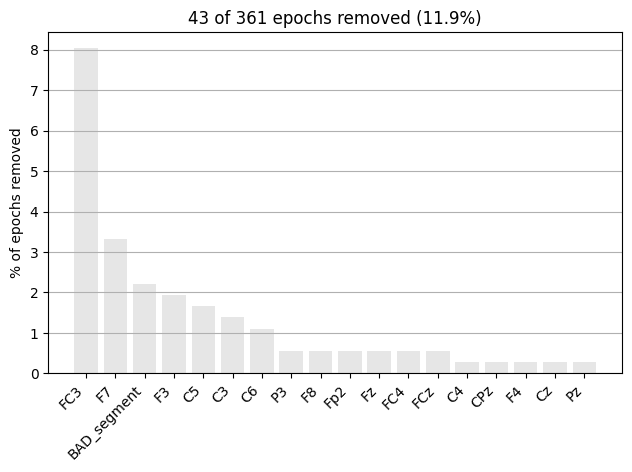

In [136]:
# rejecting epochs based on channel amplitude

reject_criteria = dict(eeg = 150e-6) # 150 µV

epochs = mne.Epochs(interp, events_from_annot, tmin=-0.2, tmax=0.8,
                    reject=reject_criteria, event_id=event_dict,
                    reject_by_annotation=True, preload=True)
epochs.plot_drop_log()

In [137]:
# low-pass filter epochs

epoch_lpass = epochs.copy().filter(l_freq = None, h_freq = 30)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 451 samples (0.440 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 9540 out of 9540 | elapsed:    2.4s finished


In [ ]:
epoch_lpass.plot_image(combine='mean')

## Save file after preprocessing

At this point I think it's done so let's save it:

In [138]:
eponame = str(subject) + '_N400_epo.fif'
saveloc = os.path.join('C:\\', 'Users', 'nestea', 'eeg-notebooks', 'introeeg_labs','N400')
savename = os.path.join(saveloc, eponame)
epoch_lpass.save(savename)

## Notes for biosemi files later

In order to append files (e.g. 13842) use the raw.append method to append the raw objects.

Note from MNE's tutorial -
Be careful when concatenating Raw objects from different recordings, especially when saving: append() only preserves the info attribute of the initial Raw object (the one outside the append() method call).